In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Get files

###From CipiOrhei/TMBuD

In [2]:
# import pathlib

# if not pathlib.Path('TMBuD').exists():
#     !git clone https://github.com/CipiOrhei/TMBuD.git

# !mv TMBuD/files.txt /content
# !mv TMBuD/DATASET\ SPLIT.csv /content
# !mv TMBuD/gt_label /content
# !mv TMBuD/images /content

# !sed -i 's/import thinning/#import thinning/' TMBuD/parse_database.py
# !python TMBuD/parse_database.py --variant SEMSEG_EVAL_FULL

###From CMP Facade Database

In [ ]:
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

!mkdir /content/CMP_facade
!mkdir /content/CMP_facade_x
!unzip /content/CMP_facade_DB_base.zip -d /content/CMP_facade/
!unzip /content/CMP_facade_DB_extended.zip -d /content/CMP_facade_x/

##Imports

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
!pip install xmltodict
import xmltodict

##Create dataset

In [5]:
#@title Getting files pathes
base_data_path = '/content/CMP_facade/base'
extended_data_path = '/content/CMP_facade_x/extended'

base_image_paths = sorted([os.path.join(base_data_path, img) \
                           for img in os.listdir(base_data_path) \
                           if img.split('.')[-1] == 'jpg'])
base_mask_paths = sorted([os.path.join(base_data_path, mask) \
                          for mask in os.listdir(base_data_path) \
                          if mask.split('.')[-1] == 'png'])
base_annot_paths = sorted([os.path.join(base_data_path, annot) \
                          for annot in os.listdir(base_data_path) \
                          if annot.split('.')[-1] == 'xml'])

extended_image_paths = sorted([os.path.join(extended_data_path, img) \
                               for img in os.listdir(extended_data_path) \
                               if img.split('.')[-1] == 'jpg'])
extended_mask_paths = sorted([os.path.join(extended_data_path, mask) \
                              for mask in os.listdir(extended_data_path) \
                              if mask.split('.')[-1] == 'png'])
extended_annot_paths = sorted([os.path.join(extended_data_path, annot) \
                              for annot in os.listdir(extended_data_path) \
                              if annot.split('.')[-1] == 'xml'])

print(f'Base images - {len(base_image_paths)}, base masks - {len(base_mask_paths)}')
print(f'Extended images - {len(extended_image_paths)}, extended masks - {len(extended_mask_paths)}')

all_image_paths = base_image_paths + extended_image_paths
all_mask_paths = base_mask_paths + extended_mask_paths
all_annot_paths = base_annot_paths + extended_annot_paths

print(f'All images - {len(all_image_paths)}, all masks - {len(all_mask_paths)}')

Base images - 378, base masks - 378
Extended images - 228, extended masks - 228
All images - 606, all masks - 606


In [6]:
#@title Support functions
def imageLoadPreprocess(image_path=None, mask_path=None):
    if image_path is not None:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image.set_shape([None, None, 3])
        resized_image = tf.image.resize(image, (256, 256))
        return resized_image
    if mask_path is not None:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_image(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask.set_shape([None, None, 1])
        resized_mask = tf.image.resize(mask, (256, 256))
        return resized_mask

def showImageMaskPair(image, mask):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image, interpolation='none')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image, interpolation='none')
    plt.imshow(mask, 'jet', interpolation='none', alpha=0.7)
    plt.title('Masked')
    plt.axis('off')
    plt.show()

In [7]:
num_imgs = 580
buildings_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
buildings_dataset = buildings_dataset.map(lambda x: imageLoadPreprocess(image_path=x))

masks_dataset = tf.data.Dataset.from_tensor_slices(all_mask_paths)
masks_dataset = masks_dataset.map(lambda x: imageLoadPreprocess(mask_path=x))

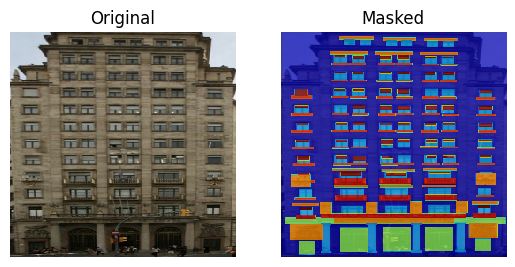

In [8]:
example_b = buildings_dataset.take(1).get_single_element()
example_m = masks_dataset.take(1).get_single_element()
showImageMaskPair(example_b, example_m)

In [9]:
# @title Dict way to get masks coordinates (slower)
def getWindowsPointsFromDict(annot_path):
    """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
    of windows bounding boxes"""
    with open(annot_path) as f:
        xml = f.read()
    xml_dict = xmltodict.parse("<root>" + xml + "</root>")['root']['object']

    windows_points = []
    for obj in xml_dict:
        if obj.get('labelname') == 'window':
            x_points = obj.get('points').get('x')
            y_points = obj.get('points').get('y')
            rx_min, rx_max = float(x_points[0]), float(x_points[1])
            ry_min, ry_max = float(y_points[0]), float(y_points[1])
            windows_points.append([rx_min, rx_max, ry_min, ry_max])
    return windows_points

%time getWindowsPointsFromDict(all_annot_paths[0])
print('Done')

CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 22.2 ms
Done


In [10]:
# @title XML ElementTree way to get masks coordinates (faster)
def getWindowsPoints(annot_path):
    """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
    of windows bounding boxes"""
    with open(annot_path) as f:
        xml = f.read()
    tree = ET.fromstring("<root>" + xml + "</root>")

    windows_points = []
    for obj in tree:
        labelname = obj.find('labelname').text[1:-1]
        points = obj.find('points')
        if labelname == 'window':
            x_points = points.findall('x')
            y_points = points.findall('y')
            rx_min, rx_max = float(x_points[0].text), float(x_points[1].text)
            ry_min, ry_max = float(y_points[0].text), float(y_points[1].text)
            windows_points.append([rx_min, rx_max, ry_min, ry_max])
    return windows_points

%time getWindowsPoints(all_annot_paths[0])
print('Done')

CPU times: user 3.19 ms, sys: 349 µs, total: 3.54 ms
Wall time: 4.07 ms
Done


In [11]:
#@title Support functions
def getWindowsPointsDataset(annots_paths):
    return [getWindowsPoints(annot_path) for annot_path in annots_paths]

def getWindowsSegments(windows_coords, image_shape):
    bg = np.zeros(image_shape, dtype=np.float32)
    for window in windows_coords:
        x_min, x_max = int(window[0] * bg.shape[0]), int(window[1] * bg.shape[0])
        y_min, y_max = int(window[2] * bg.shape[1]), int(window[3] * bg.shape[1])
        bg[x_min:x_max, y_min:y_max] = 1.0
    bg = tf.constant(bg)
    return bg

def getAllBuildingsWindowsSegments(all_windows_coords, images_shapes):
    windows_segs_dataset = []
    for i in range(len(all_windows_coords)):
        windows_segs = getWindowsSegments(all_windows_coords[i], images_shapes[i])
        windows_segs_dataset.append(windows_segs)
    return windows_segs_dataset

In [12]:
all_buildings_windows_coords = getWindowsPointsDataset(all_annot_paths)

In [13]:
images_shapes = [image.shape for image in buildings_dataset.as_numpy_iterator()]
building_windows = getAllBuildingsWindowsSegments(all_buildings_windows_coords, images_shapes)

In [14]:
windows_dataset = tf.data.Dataset.from_tensor_slices(building_windows)
windows_dataset = windows_dataset.map(tf.image.rgb_to_grayscale)

In [21]:
dataset = tf.data.Dataset.zip(buildings_dataset, windows_dataset)

train_size = int(dataset.cardinality().numpy() * 0.8)
train_data = dataset.take(train_size)
test_data = dataset.skip(train_size)

val_size = int(test_data.cardinality().numpy() * 0.8)
val_data = test_data.take(val_size)
test_data = test_data.skip(val_size)

print(f'Train size = {train_data.cardinality().numpy()}')
print(f'Val size = {val_data.cardinality().numpy()}')
print(f'Test size = {test_data.cardinality().numpy()}')

train_data = train_data.batch(16)
val_data = val_data.batch(16)
test_data = test_data.batch(16)

Train size = 484
Val size = 97
Test size = 25


##Create model

In [17]:
def buildUNetModel():
    x = tf.keras.layers.Input((256, 256, 3))

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out1)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out2)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out3)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out4)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

##Train model

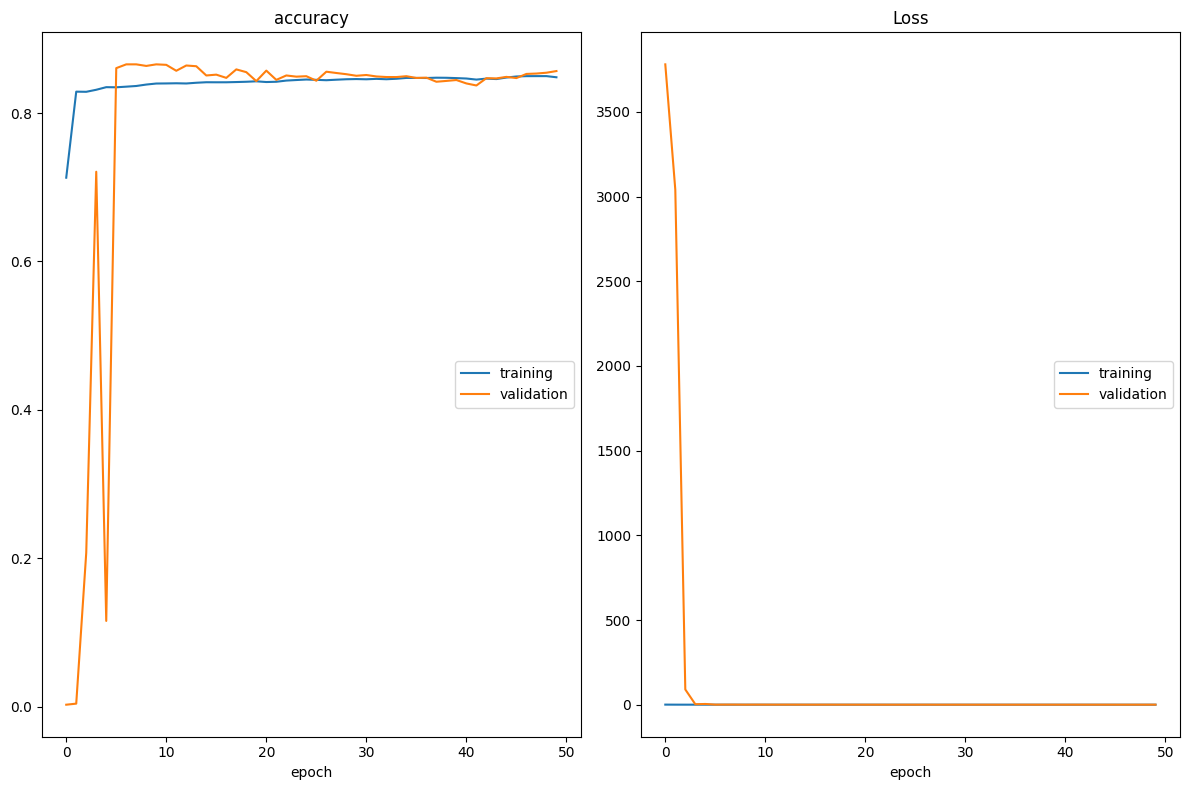

accuracy
	training         	 (min:    0.713, max:    0.850, cur:    0.848)
	validation       	 (min:    0.003, max:    0.866, cur:    0.857)
Loss
	training         	 (min:    0.036, max:    0.558, cur:    0.041)
	validation       	 (min:    0.222, max: 3780.156, cur:    0.301)
31/31 [==============================] - 43s 1s/step - loss: 0.0411 - accuracy: 0.8482 - val_loss: 0.3012 - val_accuracy: 0.8566


In [22]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
EPOCHS = 50

model = buildUNetModel()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=EPOCHS,
                 callbacks=[PlotLossesCallback()]
                 )

model.save(model_path)

In [23]:
model.evaluate(test_data)

2/2 [==============================] - 8s 5s/step - loss: 0.4693 - accuracy: 0.8450


[0.4692530035972595, 0.8450097441673279]

##Load model

In [21]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
model = tf.keras.saving.load_model(model_path)

##Get segmentation

In [58]:
#@title Support functions
def getSomePredictions(data, n=3):
    data = (data
            .unbatch()
            .shuffle(50)
            .take(n)
            .as_numpy_iterator())

    for img, label in data:
        pred = model.predict(img[None, ...])
        seg_map = (pred[0, ..., 0] > 0.5).astype(np.float32)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(img, interpolation='none')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(img, interpolation='none')
        plt.imshow(label, 'jet', interpolation='none', alpha=0.7)
        plt.title('Ground truth')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(img, interpolation='none')
        plt.imshow(seg_map, 'jet', interpolation='none', alpha=0.7)
        plt.title('Masked')
        plt.axis('off')
        plt.show()

1/1 [==============================] - 0s 30ms/step


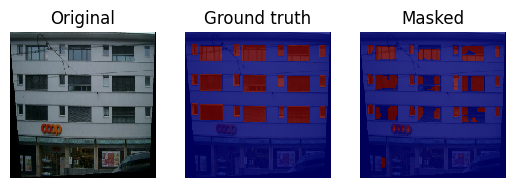

1/1 [==============================] - 0s 48ms/step


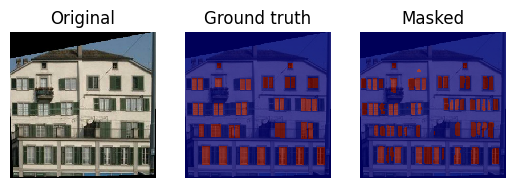

1/1 [==============================] - 0s 35ms/step


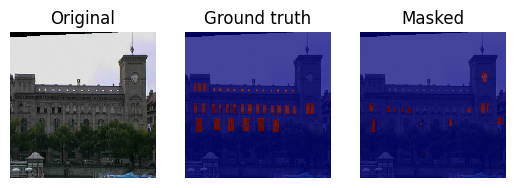

1/1 [==============================] - 0s 34ms/step


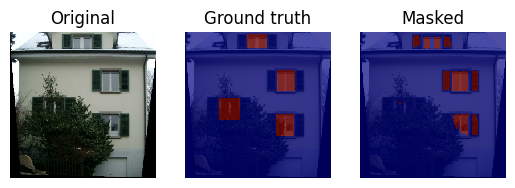

1/1 [==============================] - 0s 36ms/step


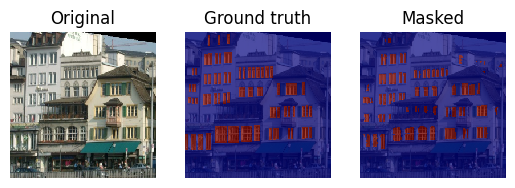

In [60]:
getSomePredictions(test_data, n=5)

##Get contours